In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
#!pip install torch

In [1]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
from matplotlib import pyplot as plt

import copy
import pickle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}

background_classes = {'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck'}

# print(type(foreground_classes))

In [ ]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):   #5000*batch_size = 50000 data points
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [ ]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, axes = (1, 2, 0)))
  plt.show()

In [ ]:

img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())

In [ ]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]  #-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [ ]:
desired_num = 90000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)

In [ ]:
dict_mos_list_images = {"mosaic_list_ofimages": mosaic_list_of_images}
dict_mos_labels ={"mosaic_label":mosaic_label}
dict_fore_idx = {"fore_idx":fore_idx}

In [ ]:
f = open("mosaic_list_images.pkl","wb")
pickle.dump(dict_mos_list_images,f)
f.close()

In [ ]:
f = open("mosaic_label.pkl","wb")
pickle.dump(dict_mos_labels,f)
f.close()

In [ ]:
f = open("fore_idx.pkl","wb")
pickle.dump(dict_fore_idx,f)
f.close()

# Load data from saved file 

In [2]:
with open('mosaic_list_images.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
mosaic_list_of_images = data["mosaic_list_ofimages"]

In [4]:
with open('mosaic_label.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
mosaic_label = data["mosaic_label"]

In [6]:
with open('fore_idx.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
fore_idx = data["fore_idx"]

In [8]:
print(len(mosaic_list_of_images) , len(mosaic_label), len(mosaic_list_of_images[0:10000]))
print(fore_idx)

90000 90000 10000
[1, 7, 0, 0, 4, 1, 6, 2, 1, 2, 4, 0, 2, 8, 7, 3, 5, 8, 7, 1, 8, 7, 2, 7, 6, 0, 7, 7, 2, 8, 1, 1, 5, 4, 7, 5, 2, 5, 8, 0, 8, 6, 5, 7, 8, 5, 5, 8, 4, 6, 5, 5, 7, 3, 7, 5, 4, 2, 6, 5, 3, 5, 7, 7, 5, 2, 1, 6, 1, 5, 5, 7, 3, 0, 2, 0, 0, 0, 2, 4, 8, 0, 1, 0, 2, 5, 2, 8, 3, 3, 5, 6, 0, 5, 2, 1, 4, 7, 4, 2, 3, 7, 7, 5, 0, 0, 8, 7, 5, 3, 6, 6, 5, 0, 1, 4, 7, 3, 7, 7, 0, 5, 2, 6, 0, 3, 6, 3, 3, 5, 2, 4, 6, 0, 4, 3, 8, 2, 2, 8, 2, 4, 2, 6, 3, 8, 0, 2, 5, 3, 1, 4, 3, 0, 6, 7, 6, 4, 2, 3, 5, 8, 5, 8, 3, 8, 4, 4, 6, 0, 7, 7, 3, 6, 3, 4, 2, 2, 1, 1, 6, 4, 2, 8, 1, 4, 3, 4, 8, 0, 3, 6, 5, 5, 2, 3, 8, 2, 0, 0, 0, 0, 7, 6, 7, 5, 1, 4, 7, 5, 2, 4, 2, 5, 3, 1, 6, 7, 8, 2, 5, 4, 1, 4, 3, 4, 4, 7, 7, 4, 4, 8, 5, 8, 3, 5, 5, 4, 6, 8, 4, 7, 7, 7, 0, 2, 0, 5, 0, 8, 1, 6, 4, 7, 3, 4, 8, 8, 2, 7, 1, 7, 5, 3, 7, 7, 2, 8, 5, 6, 7, 7, 6, 2, 7, 6, 4, 8, 3, 8, 0, 0, 3, 5, 5, 0, 7, 2, 6, 2, 3, 1, 7, 1, 2, 4, 0, 1, 5, 0, 3, 4, 8, 4, 0, 0, 6, 3, 4, 4, 5, 3, 1, 3, 3, 5, 1, 1, 8, 0, 6, 5, 0, 3, 4, 8, 1, 

In [9]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([3, 32,32], dtype=torch.float64)
    for j in range(9):
      if j == foreground_index[i]:
        img = img + mosaic_dataset[i][j]*dataset_number/9
      else :
        img = img + mosaic_dataset[i][j]*(9-dataset_number)/(8*9)
    
    avg_image_dataset.append(img)
    
  return avg_image_dataset , labels , foreground_index
        
  

In [10]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000], fore_idx[0:10000] , 1)
avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[10000:20000], mosaic_label[10000:20000], fore_idx[10000:20000] , 2)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[20000:30000], mosaic_label[20000:30000], fore_idx[20000:30000] , 3)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[30000:40000], mosaic_label[30000:40000], fore_idx[30000:40000] , 4)
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[40000:50000], mosaic_label[40000:50000], fore_idx[40000:50000] , 5)
avg_image_dataset_6 , labels_6,  fg_index_6 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[50000:60000], mosaic_label[50000:60000], fore_idx[50000:60000] , 6)
avg_image_dataset_7 , labels_7,  fg_index_7 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[60000:70000], mosaic_label[60000:70000], fore_idx[60000:70000] , 7)
avg_image_dataset_8 , labels_8,  fg_index_8 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[70000:80000], mosaic_label[70000:80000], fore_idx[70000:80000] , 8)
avg_image_dataset_9 , labels_9,  fg_index_9 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[80000:90000], mosaic_label[80000:90000], fore_idx[80000:90000] , 9)



In [11]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [12]:
batch = 256
epochs = 65

# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)

testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

In [32]:
class Module2(nn.Module):
    def __init__(self):
        super(Module2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,3)

    def forward(self,z):  #z batch of list of 9 images

        y1 = self.pool(F.relu(self.conv1(z)))
        y1 = self.pool(F.relu(self.conv2(y1)))
        y1 = y1.view(-1, 16 * 5 * 5)

        y1 = F.relu(self.fc1(y1))
        y1 = F.relu(self.fc2(y1))
        y1 = F.relu(self.fc3(y1))
        y1 = self.fc4(y1)
        return y1 

In [33]:
def test_all(number, testloader,inc):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= inc(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test dataset %d: %d %%' % (number , 100 * correct / total))

In [34]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    
    inc = Module2().double()
    inc = inc.to("cuda")
    
    criterion_inception = nn.CrossEntropyLoss()
    optimizer_inception = optim.SGD(inc.parameters(), lr=0.01, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 150
    
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_inception.zero_grad()

            # forward + backward + optimize
            outputs = inc(inputs)
            loss = criterion_inception(outputs, labels)
            loss.backward()
            optimizer_inception.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                ep_lossi.append(running_loss/10) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(np.mean(ep_lossi))   #loss per epoch
    #     if (epoch%5 == 0):
    #         _,actis= inc(inputs)
    #         acti.append(actis)



    print('Finished Training')
    torch.save(inc.state_dict(),"train_dataset_simp_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = inc(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 train images: %d %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,inc)
    
    print("--"*40)
    
    return loss_curi
    

In [35]:
train_loss_all=[]

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9]

train_loss_all.append(train_all(trainloader_1, 1, testloader_list))
train_loss_all.append(train_all(trainloader_2, 2, testloader_list))
train_loss_all.append(train_all(trainloader_3, 3, testloader_list))
train_loss_all.append(train_all(trainloader_4, 4, testloader_list))
train_loss_all.append(train_all(trainloader_5, 5, testloader_list))
train_loss_all.append(train_all(trainloader_6, 6, testloader_list))
train_loss_all.append(train_all(trainloader_7, 7, testloader_list))
train_loss_all.append(train_all(trainloader_8, 8, testloader_list))
train_loss_all.append(train_all(trainloader_9, 9, testloader_list))

--------------------------------------------------------------------------------
training on data set   1
[1,    10] loss: 1.111
[1,    20] loss: 1.108
[1,    30] loss: 1.106
[1,    40] loss: 1.101
[2,    10] loss: 1.100
[2,    20] loss: 1.099
[2,    30] loss: 1.098
[2,    40] loss: 1.099
[3,    10] loss: 1.098
[3,    20] loss: 1.099
[3,    30] loss: 1.099
[3,    40] loss: 1.099
[4,    10] loss: 1.099
[4,    20] loss: 1.099
[4,    30] loss: 1.099
[4,    40] loss: 1.099
[5,    10] loss: 1.099
[5,    20] loss: 1.098
[5,    30] loss: 1.099
[5,    40] loss: 1.099
[6,    10] loss: 1.098
[6,    20] loss: 1.099
[6,    30] loss: 1.099
[6,    40] loss: 1.098
[7,    10] loss: 1.099
[7,    20] loss: 1.098
[7,    30] loss: 1.099
[7,    40] loss: 1.099
[8,    10] loss: 1.099
[8,    20] loss: 1.099
[8,    30] loss: 1.099
[8,    40] loss: 1.099
[9,    10] loss: 1.099
[9,    20] loss: 1.099
[9,    30] loss: 1.099
[9,    40] loss: 1.098
[10,    10] loss: 1.099
[10,    20] loss: 1.099
[10,    30] loss: 

[86,    20] loss: 1.045
[86,    30] loss: 1.026
[86,    40] loss: 1.026
[87,    10] loss: 1.023
[87,    20] loss: 1.034
[87,    30] loss: 1.027
[87,    40] loss: 1.021
[88,    10] loss: 1.039
[88,    20] loss: 1.029
[88,    30] loss: 1.023
[88,    40] loss: 1.018
[89,    10] loss: 1.039
[89,    20] loss: 1.044
[89,    30] loss: 1.026
[89,    40] loss: 1.054
[90,    10] loss: 1.044
[90,    20] loss: 1.036
[90,    30] loss: 1.014
[90,    40] loss: 1.030
[91,    10] loss: 1.033
[91,    20] loss: 1.010
[91,    30] loss: 1.014
[91,    40] loss: 1.025
[92,    10] loss: 1.023
[92,    20] loss: 1.024
[92,    30] loss: 1.028
[92,    40] loss: 1.013
[93,    10] loss: 1.015
[93,    20] loss: 1.010
[93,    30] loss: 1.030
[93,    40] loss: 1.013
[94,    10] loss: 1.013
[94,    20] loss: 1.021
[94,    30] loss: 1.019
[94,    40] loss: 1.034
[95,    10] loss: 1.014
[95,    20] loss: 1.024
[95,    30] loss: 1.015
[95,    40] loss: 1.033
[96,    10] loss: 1.023
[96,    20] loss: 1.013
[96,    30] loss

[12,    10] loss: 1.081
[12,    20] loss: 1.080
[12,    30] loss: 1.069
[12,    40] loss: 1.069
[13,    10] loss: 1.065
[13,    20] loss: 1.064
[13,    30] loss: 1.059
[13,    40] loss: 1.048
[14,    10] loss: 1.057
[14,    20] loss: 1.043
[14,    30] loss: 1.040
[14,    40] loss: 1.030
[15,    10] loss: 1.028
[15,    20] loss: 1.016
[15,    30] loss: 1.024
[15,    40] loss: 1.028
[16,    10] loss: 1.005
[16,    20] loss: 1.030
[16,    30] loss: 1.002
[16,    40] loss: 1.010
[17,    10] loss: 1.000
[17,    20] loss: 1.010
[17,    30] loss: 0.994
[17,    40] loss: 1.001
[18,    10] loss: 0.985
[18,    20] loss: 0.988
[18,    30] loss: 0.995
[18,    40] loss: 0.991
[19,    10] loss: 0.991
[19,    20] loss: 0.973
[19,    30] loss: 1.002
[19,    40] loss: 0.981
[20,    10] loss: 0.980
[20,    20] loss: 0.976
[20,    30] loss: 0.966
[20,    40] loss: 0.953
[21,    10] loss: 0.979
[21,    20] loss: 0.975
[21,    30] loss: 0.948
[21,    40] loss: 0.954
[22,    10] loss: 0.956
[22,    20] loss

[97,    30] loss: 0.048
[97,    40] loss: 0.066
[98,    10] loss: 0.073
[98,    20] loss: 0.056
[98,    30] loss: 0.055
[98,    40] loss: 0.040
[99,    10] loss: 0.036
[99,    20] loss: 0.036
[99,    30] loss: 0.033
[99,    40] loss: 0.043
[100,    10] loss: 0.286
[100,    20] loss: 0.330
[100,    30] loss: 0.253
[100,    40] loss: 0.199
[101,    10] loss: 0.123
[101,    20] loss: 0.105
[101,    30] loss: 0.090
[101,    40] loss: 0.071
[102,    10] loss: 0.042
[102,    20] loss: 0.038
[102,    30] loss: 0.044
[102,    40] loss: 0.061
[103,    10] loss: 0.316
[103,    20] loss: 0.194
[103,    30] loss: 0.145
[103,    40] loss: 0.113
[104,    10] loss: 0.071
[104,    20] loss: 0.078
[104,    30] loss: 0.080
[104,    40] loss: 0.105
[105,    10] loss: 0.080
[105,    20] loss: 0.052
[105,    30] loss: 0.042
[105,    40] loss: 0.043
[106,    10] loss: 0.049
[106,    20] loss: 0.034
[106,    30] loss: 0.030
[106,    40] loss: 0.044
[107,    10] loss: 0.026
[107,    20] loss: 0.017
[107,    3

[23,    20] loss: 0.639
[23,    30] loss: 0.645
[23,    40] loss: 0.635
[24,    10] loss: 0.703
[24,    20] loss: 0.666
[24,    30] loss: 0.666
[24,    40] loss: 0.639
[25,    10] loss: 0.629
[25,    20] loss: 0.635
[25,    30] loss: 0.608
[25,    40] loss: 0.586
[26,    10] loss: 0.593
[26,    20] loss: 0.593
[26,    30] loss: 0.606
[26,    40] loss: 0.571
[27,    10] loss: 0.588
[27,    20] loss: 0.625
[27,    30] loss: 0.595
[27,    40] loss: 0.538
[28,    10] loss: 0.619
[28,    20] loss: 0.573
[28,    30] loss: 0.586
[28,    40] loss: 0.534
[29,    10] loss: 0.559
[29,    20] loss: 0.574
[29,    30] loss: 0.576
[29,    40] loss: 0.570
[30,    10] loss: 0.709
[30,    20] loss: 0.602
[30,    30] loss: 0.577
[30,    40] loss: 0.546
[31,    10] loss: 0.543
[31,    20] loss: 0.575
[31,    30] loss: 0.552
[31,    40] loss: 0.552
[32,    10] loss: 0.577
[32,    20] loss: 0.558
[32,    30] loss: 0.574
[32,    40] loss: 0.514
[33,    10] loss: 0.557
[33,    20] loss: 0.532
[33,    30] loss

[108,    40] loss: 0.001
[109,    10] loss: 0.001
[109,    20] loss: 0.001
[109,    30] loss: 0.000
[109,    40] loss: 0.001
[110,    10] loss: 0.001
[110,    20] loss: 0.001
[110,    30] loss: 0.001
[110,    40] loss: 0.000
[111,    10] loss: 0.001
[111,    20] loss: 0.001
[111,    30] loss: 0.000
[111,    40] loss: 0.001
[112,    10] loss: 0.000
[112,    20] loss: 0.000
[112,    30] loss: 0.000
[112,    40] loss: 0.001
[113,    10] loss: 0.000
[113,    20] loss: 0.000
[113,    30] loss: 0.000
[113,    40] loss: 0.001
[114,    10] loss: 0.000
[114,    20] loss: 0.001
[114,    30] loss: 0.001
[114,    40] loss: 0.000
[115,    10] loss: 0.000
[115,    20] loss: 0.000
[115,    30] loss: 0.000
[115,    40] loss: 0.000
[116,    10] loss: 0.000
[116,    20] loss: 0.000
[116,    30] loss: 0.000
[116,    40] loss: 0.000
[117,    10] loss: 0.000
[117,    20] loss: 0.000
[117,    30] loss: 0.000
[117,    40] loss: 0.000
[118,    10] loss: 0.000
[118,    20] loss: 0.000
[118,    30] loss: 0.000


[35,    20] loss: 0.346
[35,    30] loss: 0.373
[35,    40] loss: 0.351
[36,    10] loss: 0.347
[36,    20] loss: 0.351
[36,    30] loss: 0.316
[36,    40] loss: 0.305
[37,    10] loss: 0.288
[37,    20] loss: 0.304
[37,    30] loss: 0.337
[37,    40] loss: 0.345
[38,    10] loss: 0.329
[38,    20] loss: 0.311
[38,    30] loss: 0.299
[38,    40] loss: 0.274
[39,    10] loss: 0.277
[39,    20] loss: 0.270
[39,    30] loss: 0.284
[39,    40] loss: 0.271
[40,    10] loss: 0.287
[40,    20] loss: 0.278
[40,    30] loss: 0.291
[40,    40] loss: 0.282
[41,    10] loss: 0.311
[41,    20] loss: 0.276
[41,    30] loss: 0.263
[41,    40] loss: 0.242
[42,    10] loss: 0.252
[42,    20] loss: 0.219
[42,    30] loss: 0.250
[42,    40] loss: 0.234
[43,    10] loss: 0.282
[43,    20] loss: 0.264
[43,    30] loss: 0.244
[43,    40] loss: 0.219
[44,    10] loss: 0.201
[44,    20] loss: 0.210
[44,    30] loss: 0.231
[44,    40] loss: 0.212
[45,    10] loss: 0.175
[45,    20] loss: 0.216
[45,    30] loss

[120,    10] loss: 0.000
[120,    20] loss: 0.000
[120,    30] loss: 0.000
[120,    40] loss: 0.000
[121,    10] loss: 0.000
[121,    20] loss: 0.000
[121,    30] loss: 0.000
[121,    40] loss: 0.000
[122,    10] loss: 0.000
[122,    20] loss: 0.000
[122,    30] loss: 0.000
[122,    40] loss: 0.000
[123,    10] loss: 0.000
[123,    20] loss: 0.000
[123,    30] loss: 0.000
[123,    40] loss: 0.000
[124,    10] loss: 0.000
[124,    20] loss: 0.000
[124,    30] loss: 0.000
[124,    40] loss: 0.000
[125,    10] loss: 0.000
[125,    20] loss: 0.000
[125,    30] loss: 0.000
[125,    40] loss: 0.000
[126,    10] loss: 0.000
[126,    20] loss: 0.000
[126,    30] loss: 0.000
[126,    40] loss: 0.000
[127,    10] loss: 0.000
[127,    20] loss: 0.000
[127,    30] loss: 0.000
[127,    40] loss: 0.000
[128,    10] loss: 0.000
[128,    20] loss: 0.000
[128,    30] loss: 0.000
[128,    40] loss: 0.000
[129,    10] loss: 0.000
[129,    20] loss: 0.000
[129,    30] loss: 0.000
[129,    40] loss: 0.000


[46,    30] loss: 0.226
[46,    40] loss: 0.215
[47,    10] loss: 0.215
[47,    20] loss: 0.215
[47,    30] loss: 0.212
[47,    40] loss: 0.211
[48,    10] loss: 0.316
[48,    20] loss: 0.238
[48,    30] loss: 0.221
[48,    40] loss: 0.216
[49,    10] loss: 0.262
[49,    20] loss: 0.262
[49,    30] loss: 0.238
[49,    40] loss: 0.218
[50,    10] loss: 0.212
[50,    20] loss: 0.174
[50,    30] loss: 0.180
[50,    40] loss: 0.152
[51,    10] loss: 0.153
[51,    20] loss: 0.182
[51,    30] loss: 0.170
[51,    40] loss: 0.182
[52,    10] loss: 0.148
[52,    20] loss: 0.129
[52,    30] loss: 0.131
[52,    40] loss: 0.185
[53,    10] loss: 0.165
[53,    20] loss: 0.144
[53,    30] loss: 0.142
[53,    40] loss: 0.131
[54,    10] loss: 0.106
[54,    20] loss: 0.098
[54,    30] loss: 0.106
[54,    40] loss: 0.100
[55,    10] loss: 0.105
[55,    20] loss: 0.117
[55,    30] loss: 0.120
[55,    40] loss: 0.163
[56,    10] loss: 0.153
[56,    20] loss: 0.128
[56,    30] loss: 0.136
[56,    40] loss

[131,    20] loss: 0.000
[131,    30] loss: 0.000
[131,    40] loss: 0.000
[132,    10] loss: 0.000
[132,    20] loss: 0.000
[132,    30] loss: 0.000
[132,    40] loss: 0.000
[133,    10] loss: 0.000
[133,    20] loss: 0.000
[133,    30] loss: 0.000
[133,    40] loss: 0.000
[134,    10] loss: 0.000
[134,    20] loss: 0.000
[134,    30] loss: 0.000
[134,    40] loss: 0.000
[135,    10] loss: 0.000
[135,    20] loss: 0.000
[135,    30] loss: 0.000
[135,    40] loss: 0.000
[136,    10] loss: 0.000
[136,    20] loss: 0.000
[136,    30] loss: 0.000
[136,    40] loss: 0.000
[137,    10] loss: 0.000
[137,    20] loss: 0.000
[137,    30] loss: 0.000
[137,    40] loss: 0.000
[138,    10] loss: 0.000
[138,    20] loss: 0.000
[138,    30] loss: 0.000
[138,    40] loss: 0.000
[139,    10] loss: 0.000
[139,    20] loss: 0.000
[139,    30] loss: 0.000
[139,    40] loss: 0.000
[140,    10] loss: 0.000
[140,    20] loss: 0.000
[140,    30] loss: 0.000
[140,    40] loss: 0.000
[141,    10] loss: 0.000


[58,    30] loss: 0.013
[58,    40] loss: 0.012
[59,    10] loss: 0.010
[59,    20] loss: 0.015
[59,    30] loss: 0.007
[59,    40] loss: 0.007
[60,    10] loss: 0.008
[60,    20] loss: 0.009
[60,    30] loss: 0.007
[60,    40] loss: 0.010
[61,    10] loss: 0.006
[61,    20] loss: 0.012
[61,    30] loss: 0.008
[61,    40] loss: 0.008
[62,    10] loss: 0.007
[62,    20] loss: 0.008
[62,    30] loss: 0.008
[62,    40] loss: 0.009
[63,    10] loss: 0.008
[63,    20] loss: 0.006
[63,    30] loss: 0.006
[63,    40] loss: 0.007
[64,    10] loss: 0.006
[64,    20] loss: 0.008
[64,    30] loss: 0.004
[64,    40] loss: 0.003
[65,    10] loss: 0.007
[65,    20] loss: 0.005
[65,    30] loss: 0.003
[65,    40] loss: 0.004
[66,    10] loss: 0.003
[66,    20] loss: 0.002
[66,    30] loss: 0.003
[66,    40] loss: 0.006
[67,    10] loss: 0.004
[67,    20] loss: 0.002
[67,    30] loss: 0.004
[67,    40] loss: 0.003
[68,    10] loss: 0.004
[68,    20] loss: 0.003
[68,    30] loss: 0.002
[68,    40] loss

[142,    30] loss: 0.000
[142,    40] loss: 0.000
[143,    10] loss: 0.000
[143,    20] loss: 0.000
[143,    30] loss: 0.000
[143,    40] loss: 0.000
[144,    10] loss: 0.000
[144,    20] loss: 0.000
[144,    30] loss: 0.000
[144,    40] loss: 0.000
[145,    10] loss: 0.000
[145,    20] loss: 0.000
[145,    30] loss: 0.000
[145,    40] loss: 0.000
[146,    10] loss: 0.000
[146,    20] loss: 0.000
[146,    30] loss: 0.000
[146,    40] loss: 0.000
[147,    10] loss: 0.000
[147,    20] loss: 0.000
[147,    30] loss: 0.000
[147,    40] loss: 0.000
[148,    10] loss: 0.000
[148,    20] loss: 0.000
[148,    30] loss: 0.000
[148,    40] loss: 0.000
[149,    10] loss: 0.000
[149,    20] loss: 0.000
[149,    30] loss: 0.000
[149,    40] loss: 0.000
[150,    10] loss: 0.000
[150,    20] loss: 0.000
[150,    30] loss: 0.000
[150,    40] loss: 0.000
Finished Training
Accuracy of the network on the 10000 train images: 100 %
Accuracy of the network on the 10000 test dataset 1: 37 %
Accuracy of the n

[69,    40] loss: 0.002
[70,    10] loss: 0.001
[70,    20] loss: 0.001
[70,    30] loss: 0.001
[70,    40] loss: 0.001
[71,    10] loss: 0.001
[71,    20] loss: 0.001
[71,    30] loss: 0.001
[71,    40] loss: 0.001
[72,    10] loss: 0.001
[72,    20] loss: 0.001
[72,    30] loss: 0.001
[72,    40] loss: 0.001
[73,    10] loss: 0.001
[73,    20] loss: 0.001
[73,    30] loss: 0.001
[73,    40] loss: 0.001
[74,    10] loss: 0.001
[74,    20] loss: 0.001
[74,    30] loss: 0.001
[74,    40] loss: 0.001
[75,    10] loss: 0.001
[75,    20] loss: 0.001
[75,    30] loss: 0.001
[75,    40] loss: 0.001
[76,    10] loss: 0.001
[76,    20] loss: 0.001
[76,    30] loss: 0.001
[76,    40] loss: 0.001
[77,    10] loss: 0.001
[77,    20] loss: 0.001
[77,    30] loss: 0.001
[77,    40] loss: 0.001
[78,    10] loss: 0.001
[78,    20] loss: 0.001
[78,    30] loss: 0.001
[78,    40] loss: 0.001
[79,    10] loss: 0.001
[79,    20] loss: 0.001
[79,    30] loss: 0.001
[79,    40] loss: 0.001
[80,    10] loss

Accuracy of the network on the 10000 test dataset 3: 58 %
Accuracy of the network on the 10000 test dataset 4: 74 %
Accuracy of the network on the 10000 test dataset 5: 84 %
Accuracy of the network on the 10000 test dataset 6: 90 %
Accuracy of the network on the 10000 test dataset 7: 100 %
Accuracy of the network on the 10000 test dataset 8: 91 %
Accuracy of the network on the 10000 test dataset 9: 90 %
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
training on data set   8
[1,    10] loss: 1.124
[1,    20] loss: 1.117
[1,    30] loss: 1.106
[1,    40] loss: 1.103
[2,    10] loss: 1.099
[2,    20] loss: 1.098
[2,    30] loss: 1.098
[2,    40] loss: 1.098
[3,    10] loss: 1.097
[3,    20] loss: 1.098
[3,    30] loss: 1.097
[3,    40] loss: 1.097
[4,    10] loss: 1.096
[4,    20] loss: 1.096
[4,    30] loss: 1.095
[4,    40] loss: 1.094
[5,    10] loss: 1.093
[5,    20] loss

[81,    10] loss: 0.000
[81,    20] loss: 0.000
[81,    30] loss: 0.000
[81,    40] loss: 0.000
[82,    10] loss: 0.000
[82,    20] loss: 0.000
[82,    30] loss: 0.000
[82,    40] loss: 0.000
[83,    10] loss: 0.000
[83,    20] loss: 0.000
[83,    30] loss: 0.000
[83,    40] loss: 0.000
[84,    10] loss: 0.000
[84,    20] loss: 0.000
[84,    30] loss: 0.000
[84,    40] loss: 0.000
[85,    10] loss: 0.000
[85,    20] loss: 0.000
[85,    30] loss: 0.000
[85,    40] loss: 0.000
[86,    10] loss: 0.000
[86,    20] loss: 0.000
[86,    30] loss: 0.000
[86,    40] loss: 0.000
[87,    10] loss: 0.000
[87,    20] loss: 0.000
[87,    30] loss: 0.000
[87,    40] loss: 0.000
[88,    10] loss: 0.000
[88,    20] loss: 0.000
[88,    30] loss: 0.000
[88,    40] loss: 0.000
[89,    10] loss: 0.000
[89,    20] loss: 0.000
[89,    30] loss: 0.000
[89,    40] loss: 0.000
[90,    10] loss: 0.000
[90,    20] loss: 0.000
[90,    30] loss: 0.000
[90,    40] loss: 0.000
[91,    10] loss: 0.000
[91,    20] loss

[6,    40] loss: 0.916
[7,    10] loss: 0.892
[7,    20] loss: 0.860
[7,    30] loss: 0.836
[7,    40] loss: 0.778
[8,    10] loss: 0.785
[8,    20] loss: 0.714
[8,    30] loss: 0.681
[8,    40] loss: 0.689
[9,    10] loss: 0.709
[9,    20] loss: 0.674
[9,    30] loss: 0.631
[9,    40] loss: 0.614
[10,    10] loss: 0.642
[10,    20] loss: 0.620
[10,    30] loss: 0.598
[10,    40] loss: 0.530
[11,    10] loss: 0.547
[11,    20] loss: 0.550
[11,    30] loss: 0.542
[11,    40] loss: 0.526
[12,    10] loss: 0.563
[12,    20] loss: 0.546
[12,    30] loss: 0.500
[12,    40] loss: 0.496
[13,    10] loss: 0.515
[13,    20] loss: 0.523
[13,    30] loss: 0.487
[13,    40] loss: 0.494
[14,    10] loss: 0.473
[14,    20] loss: 0.435
[14,    30] loss: 0.463
[14,    40] loss: 0.458
[15,    10] loss: 0.448
[15,    20] loss: 0.427
[15,    30] loss: 0.426
[15,    40] loss: 0.392
[16,    10] loss: 0.440
[16,    20] loss: 0.392
[16,    30] loss: 0.395
[16,    40] loss: 0.390
[17,    10] loss: 0.562
[17, 

[92,    20] loss: 0.000
[92,    30] loss: 0.000
[92,    40] loss: 0.000
[93,    10] loss: 0.000
[93,    20] loss: 0.000
[93,    30] loss: 0.000
[93,    40] loss: 0.000
[94,    10] loss: 0.000
[94,    20] loss: 0.000
[94,    30] loss: 0.000
[94,    40] loss: 0.000
[95,    10] loss: 0.000
[95,    20] loss: 0.000
[95,    30] loss: 0.000
[95,    40] loss: 0.000
[96,    10] loss: 0.000
[96,    20] loss: 0.000
[96,    30] loss: 0.000
[96,    40] loss: 0.000
[97,    10] loss: 0.000
[97,    20] loss: 0.000
[97,    30] loss: 0.000
[97,    40] loss: 0.000
[98,    10] loss: 0.000
[98,    20] loss: 0.000
[98,    30] loss: 0.000
[98,    40] loss: 0.000
[99,    10] loss: 0.000
[99,    20] loss: 0.000
[99,    30] loss: 0.000
[99,    40] loss: 0.000
[100,    10] loss: 0.000
[100,    20] loss: 0.000
[100,    30] loss: 0.000
[100,    40] loss: 0.000
[101,    10] loss: 0.000
[101,    20] loss: 0.000
[101,    30] loss: 0.000
[101,    40] loss: 0.000
[102,    10] loss: 0.000
[102,    20] loss: 0.000
[102, 

In [36]:
%matplotlib inline

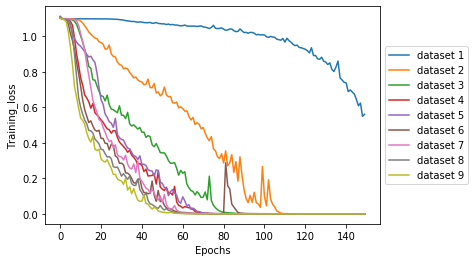

In [37]:
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+str(i+1))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))